###  Implementation of gaussian mixture model (aka mixture of gaussians) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin
from scipy.stats import multivariate_normal as mvn

In [2]:
mName = 'JL008'
expDate = '2017-09-23'

In [3]:
if False:
    NClust = int(input("How many clusters do you want to fit? "));
else:
    NClust = 3

In [4]:
dataFname = 'isodistdata_%s_%s.npy' % (mName,expDate)
X = np.load('../'+dataFname)
if np.any(np.isnan(X)):
    print('removing NaN rows...')
    print(np.shape(X))
    X = X[~np.isnan(X).any(axis=1)]
    print(np.shape(X))

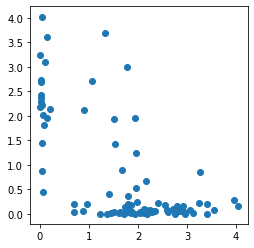

In [5]:
plt.figure(0)
plt.scatter(X[:,0], X[:,1]) 
plt.axis('square');
plt.show()

In [6]:
'''kmeans to have initial means'''
def kmeans(X,NClust,NIters=10):
    i = np.random.permutation(X.shape[0])[:NClust]
    centers = X[i]
    for itr in range(1,NIters):
        labels = pairwise_distances_argmin(X,centers)
        new_centers = np.array([X[labels == i].mean(0) for i in range(NClust)])
        centers = new_centers
    return centers,labels

def initParams(X,NClust):
    NDim            = X.shape[1]
    mu              = np.zeros((NClust, NDim))
    cov             = np.zeros((NClust, NDim, NDim))
    centers,labels  = kmeans(X,NClust) #calls own kmeans function above
    NEach           = np.bincount(labels)
    pi              = NEach/X.shape[0] #mixing proportions
    assert np.isclose(np.sum(pi),1), 'mixing proportions do not sum to 1'
    for lb in np.unique(labels):
        ix          = np.where(labels==lb)
        mu[lb,:]    = np.mean(X[ix,:])
        cov[lb,:,:] = np.dot(pi[lb] * np.squeeze(np.transpose(X[ix,:] - mu[lb,:])), 
                             np.squeeze(X[ix,:] - mu[lb,:])) / NEach[lb]
    return mu,cov,pi

'''compute posterior probability that each datapoint is in each cluster, 
i.e. the responsibilities'''
def eStep(X,mu,cov,pi,NClust):
    NCells = X.shape[0] 
    posterior = np.zeros((NCells,NClust))
    for cl in range(NClust):
        likelihood = mvn.pdf(X, mu[cl,:],cov[cl,:,:])
        prior = pi[cl]
        posterior[:,cl] = likelihood*prior 
    respb = posterior 
    resb_norm = np.sum(respb, axis=1)[:,np.newaxis]
    gamma = respb / resb_norm #normalize to make it a real pdf (sums to 1)
    return gamma

def mStep(X,gamma,NClust):
    NDim = X.shape[1]
    newPi = np.mean(gamma, axis=0) #mean per cluster
    newCov = np.zeros((NClust,NDim,NDim))
    '''new centers is "weighted (by responsibility) average", returns NDim x NClust'''
    newMu = np.transpose(1/np.sum(gamma,axis=0) * np.dot(gamma.T, X).T)
    
    for cl in range(NClust):
        meanSub = X - newMu[cl,:]
        gammaDiag = np.matrix(np.diag(gamma[:,cl]))
        covRaw = meanSub.T * gammaDiag * meanSub
        newCov[cl,:,:] = 1/np.sum(gamma,axis=0)[cl] * covRaw 
    return newPi,newMu,newCov

def getLoss(X,pi,mu,cov,gamma,NClust):
    NData = X.shape[0]
    loss = np.zeros((NData,NClust))
    for cl in range(NClust):
        dist = mvn(mu[cl,:], cov[cl],allow_singular=True)
        currloss = gamma[:,cl] * (np.log(pi[cl]+0.00001)+
                                    dist.logpdf(X)-np.log(gamma[:,cl]+0.000001))
        loss[:,cl] = currloss
    finalLoss = np.sum(loss)
    return finalLoss

def fit(X,mu,pi,cov,NClust,NIters):
    itr = 0
    lastLoss = 0
    while True:
        itr += 1
        gamma  = eStep(X,mu,cov,pi,NClust)
        pi, mu, cov = mStep(X,gamma,NClust)
        loss = getLoss(X, pi, mu, cov,gamma,NClust)
        if itr % 10 == 0:
            print("Iteration: %d Loss: %0.6f" %(itr, loss))      
        if abs(loss-lastLoss) < 1e-6:
            break
        lastLoss = loss
    return pi,mu,cov

def predict(X,mu,pi,cov,NClust):
    labels = np.zeros((X.shape[0], NClust))

    for cl in range(NClust):
        labels [:,cl] = pi[cl] * mvn.pdf(X, mu[cl,:], cov[cl])
    labels  = labels .argmax(1)
    return labels 

In [7]:
mu,cov,pi = initParams(X,NClust)
pi,mu,cov = fit(X,mu,pi,cov,NClust,100)

Iteration: 10 Loss: -135.122279
Iteration: 20 Loss: -115.124794
Iteration: 30 Loss: -103.617409


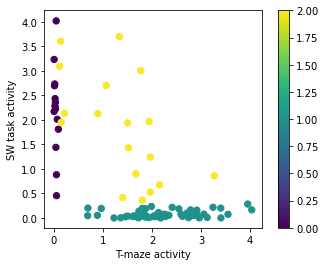

In [8]:
labels = predict(X,mu,pi,cov,NClust)
plt.figure(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, label=labels, s=40, cmap='viridis');
plt.axis('square');
plt.xlabel('T-maze activity')
plt.ylabel('SW task activity')
plt.colorbar()
plt.show()